In [0]:
%tensorflow_version 2.x

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import cv2
from imutils import paths
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf
import datetime
from glob import glob
import IPython.display as display
from IPython.display import clear_output
from google.colab import files
import math
import time
from tensorflow.keras.layers import *
import warnings
warnings.filterwarnings('ignore')
# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f'Tensorflow ver. {tf.__version__}')

Tensorflow ver. 2.2.0


In [0]:
# important for reproducibility
# this allows to generate the same random numbers
SEED = 42

# Dataset path
dataset_path = 'drive/My Drive/AppliedAICaseStudies/SemanticSegmentation/idd20k_lite/'
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'

img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'

In [0]:
def parse_image(img_path):
    """
    Load an image and its annotation (mask) and returning a dictionary.
    """
    # Reading the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # For one Image path:
    # .../idd20k_lite/leftImg8bit/train/024541_image.jpg
    # Its corresponding annotation path is:
    # .../idd20k_lite/gtFine/train/024541_label.png
    mask_path = tf.strings.regex_replace(img_path, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")
    # Reading the annotation file corresponding the image file
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess with our N_CLASS = 7
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask==255, np.dtype('uint8').type(7), mask)
    # Note that we have to convert the new value (7)
    # With the same dtype than the tensor itself
    return {'image': image, 'segmentation_mask': mask}

def normalize(input_image, input_mask):
    """
    Rescale the pixel values of the images between 0 and 1 compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

def load_image_train(datapoint):
    """
    Normalize and resize a train image and its annotation.
    Apply random transformations to an input dictionary containing a train image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    """
    Normalize and resize a test image and its annotation.
    Since this is for the test set, we don't need to apply any data augmentation technique.
    """
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def display_sample(display_list):
    """
    Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def predict(model,image_path,single_image):
    """
    This function will take the model which is going to be used to predict the image and the image path of 
    the input image as inputs and predict the mask
    It returns the true mask and predicted mask
    """
    # Getting the datapoint
    # This function will load the image and its annotation (mask) and return a dictionary.
    datapoint = parse_image(image_path)
    # Normalizing the resizing the datapoint
    input_image,image_mask = load_image_test(datapoint)
    # As the model takes input with 4 dimensions (batch_size, rows, columns, channels),
    # and the shape of the input image is (rows, columns, channels)
    # we will expand the first dimension so we will get the shape as  (1, rows, columns, channels)
    img = tf.expand_dims(input_image, 0)
    # Predicting the image by passing it to the model
    prediction = model(img)
    # The model will predict 8 outputs for each pixel
    # We have to get the maximum value out of it
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)
    # Displaying the input image, true mask, predicted mask
    if(single_image):
        display_sample([input_image, image_mask, pred_mask])
    return image_mask, pred_mask

def IoU(y_i,y_pred):
    # This function calculates the mean Intersection over Union
    # Mean IoU = TP/(FN + TP + FP)
    # This list will save the IoU of all the classes
    IoUs = []
    # Defining the number of classes which the model has predicted
    n_classes = 8
    for c in range(n_classes):
        # Calculating the True Positives
        TP = np.sum((y_i == c)&(y_pred==c))
        # Calculating the False Positives
        FP = np.sum((y_i != c)&(y_pred==c))
        # Calculating the False Negatives
        FN = np.sum((y_i == c)&(y_pred!= c))
        # Calculating the IoU for the particular class
        IoU = TP/float(TP + FP + FN)
        # Printing the outputs
        # Uncomment the print statement below when you want to analyze the results for each class
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        # Appending the IoU to the list as it mean needs to be calculated later
        if(math.isnan(IoU)):
            IoUs.append(0)
            continue
        IoUs.append(IoU)
    # Calculating the mean
    mIoU = np.mean(IoUs)
    #print("_________________")
    #print("Mean IoU: {:4.3f}".format(mIoU))
    return mIoU

In [0]:
# A class to get the basic convolution block 
# convolution_layer -> batch_normalization -> activation
class BasicConvolutionBlock(tf.keras.Model):
    
    def __init__(self, filter_size, kernel_size, dilation_rate, alpha, block_number, initializer='he_normal'):
        super(BasicConvolutionBlock, self).__init__()
        # block_number variable is used to keep a track of blocks as the structure changes slightly for 3rd and 4th block
        self.block_number = block_number
        # defining a convolution layer
        self.convolution_layer = Convolution2D(filter_size, kernel_size =  kernel_size, 
                                               dilation_rate = dilation_rate, padding = 'same',
                                               kernel_initializer = initializer)
        # defining a batch normalization layer
        self.batch_normalization = BatchNormalization()
        # defining a LeakyReLU activation layer
        self.activation = LeakyReLU(alpha = alpha)
        
    def call(self, inputs):
        # getting the convolution output
        conv_output = self.convolution_layer(inputs)
        # normalizaing the convolution output
        norm_output = self.batch_normalization(conv_output)
        # for 3rd block and 4th block, we return the normalized output without activation layer
        if(self.block_number >= 3):
            return norm_output
        # Passing the normalized output through LeakyReLU
        activation_output = self.activation(norm_output)  
        return activation_output

# A Building Block of Residual Network
class ConvolutionBlock(tf.keras.Model):
    
    def __init__(self, filters, initializer='he_normal'):     
        super(ConvolutionBlock, self).__init__()
        # The filters will be a list with 3 filter sizes (eg. [32,32,64]) where each filter size 
        # will be passed to a BasicConvolutionBlock
        self.filters = filters
        # Defining basic convolution blocks for each filter size
        self.basic_convolution_1 = BasicConvolutionBlock(self.filters[0], (1,1), (1,1), 0.2, 1)
        self.basic_convolution_2 = BasicConvolutionBlock(self.filters[1], (3,3), (2,2), 0.2, 2)
        self.basic_convolution_3 = BasicConvolutionBlock(self.filters[2], (1,1), (1,1), None, 3)
        # Defining the skip connection that is used in Residual BLocks
        self.skip_convolution = BasicConvolutionBlock(self.filters[2], (3,3), (1,1), None, 4)
        # Last Block
        self.add_layer = Add()
        self.relu_activation = ReLU()
     
    def call(self, inputs):
        # Getting the skip input
        skip_input = inputs
        # Getting the convolution outputs from BasicConvolutionBlocks
        output_conv_1 = self.basic_convolution_1(inputs)
        output_conv_2 = self.basic_convolution_2(output_conv_1)
        output_conv_3 = self.basic_convolution_3(output_conv_2)
        output_skip_conv = self.skip_convolution(skip_input)
        # Last Block
        # Adding the skip connection output and output of last convolution block
        add_output = self.add_layer([output_conv_3,output_skip_conv])
        # Passing the added output through ReLU activation
        output = self.relu_activation(add_output)
        return output

# Encoder block for PSPNet
class EncoderBlock(tf.keras.Model):
    
    def __init__(self, filters):
        super(EncoderBlock, self).__init__()
        # filters -> [[32,32,64],[64,64,128],[128,128,256],[256,256,512]]
        # Each sublist in the abover filters list will be passed to ConvolutionBlocks
        # and every single element in the sublist will be further passed to BasicConvolutionBlock
        self.filters = filters
        # Defining the convolution blocks
        self.convolution_block_1 = ConvolutionBlock(self.filters[0])
        self.convolution_block_2 = ConvolutionBlock(self.filters[1])
        self.convolution_block_3 = ConvolutionBlock(self.filters[2])
        self.convolution_block_4 = ConvolutionBlock(self.filters[3])
        
    def call(self, inputs):     
        # Passing the inputs to the Convolution Block defined above
        output_block_1 = self.convolution_block_1(inputs)
        # Passing the output of convolution blocks to futher convolution blocks
        output_block_2 = self.convolution_block_2(output_block_1)
        output_block_3 = self.convolution_block_3(output_block_2) 
        output_block_4 = self.convolution_block_4(output_block_3)
        return output_block_4
    
# This class returns the pyramid feature map for Pyramid Pooling module
# Pooling -> Convolution -> UpSampling
class PyramidFeatureMap(tf.keras.Model): 
    
    def __init__(self, block, filter_size, unsampling_size, pool_size, interpolation='bilinear'):
        super(PyramidFeatureMap, self).__init__()
        # There are 4 blocks -> red, yellow, blue, green
        # As the pooling technique is different for Red block, defining a block will help
        # to keep a track of the changes that are required for different blocks
        self.block = block
        # Defining the convolution layer
        self.convolution_layer = Convolution2D(filter_size, kernel_size = (1,1))
        # Defining the UpSampling layer
        self.upsampling_layer = UpSampling2D(unsampling_size, interpolation = interpolation)
        # Defining the average pooling layer that is going to be used for yellow, blue and green
        self.average_pooling = AveragePooling2D(pool_size)
        # Defining a global average pooling layer for red block
        self.global_average_pooling = GlobalAveragePooling2D()
        
    def call(self,inputs):
        # For Red block, we will pass the input through GlobalAveragePooling layer
        if(self.block=='red'):
            pool_output = self.global_average_pooling(inputs)
            pool_output = Reshape((1,1,512))(pool_output)
        # For all the other blocks, we will perform AveragePooling
        else:
            pool_output = self.average_pooling(inputs)
        # Passing the pooled output through convolution layer
        conv_output = self.convolution_layer(pool_output)
        # Passing the convolution output through UpSampling layer
        upsampling_output = self.upsampling_layer(conv_output)
        return upsampling_output        
    
# This class builds the Pyramid Pooling Module
# It builds the 4 feature maps and then concatenates all of them with the input
class PyramidPoolingModule(tf.keras.Model):
    
    def __init__(self):
        super(PyramidPoolingModule, self).__init__()
        # Defining the PyramidFeatureMaps for red, yellow, blue and green blocks along with the
        # filter_size, unsampling_size and pool_size
        self.block_red = PyramidFeatureMap('red', 64, (128,128), (1,1))
        self.block_yellow = PyramidFeatureMap('yellow', 64, 2, (2,2))
        self.block_blue = PyramidFeatureMap('blue', 64, 4, (4,4))
        self.block_green = PyramidFeatureMap('green', 64, 8, (8,8))
        
    def call(self,inputs):
        # Passing the inputs through each of the blocks
        red_output = self.block_red(inputs)
        yellow_output = self.block_yellow(inputs)
        blue_output = self.block_blue(inputs)
        green_output = self.block_green(inputs)
        # Concatenating the inputs with the outputs of each of the PyramidFeatureMaps
        merged = concatenate([inputs, red_output, yellow_output, blue_output, green_output])
        return merged  

# This block is for the last stage
# It gets the output of Pyramid Pooling Module and then performs convolution operation
# Pyramid Pooling Module -> Convolution -> Batch Normalization -> Softmax activation
class DecoderBlock(tf.keras.Model):
    
    def __init__(self, num_classes):
        super(DecoderBlock, self).__init__()
        # Defining the PyramidPoolingModule
        self.pyramid_pooling_module = PyramidPoolingModule()
        # Defining the Convolution Layer with filter size as number of classes
        self.convolution_layer = Convolution2D(num_classes, kernel_size = (3,3), padding = 'same')
        # Defining the BatchNormalization layer
        self.batch_norm_layer = BatchNormalization()
        # Defining the last softmax activation layer
        self.activation = Activation('softmax')
    
    def call(self, inputs):
        # Getting the PyramidPoolingModule output
        merged = self.pyramid_pooling_module(inputs)
        # Passing the PyramidPoolingModule output to ConvolutionLayer
        conv_output = self.convolution_layer(merged)
        # Passing the convolution output to BatchNormalization layer
        norm_output = self.batch_norm_layer(conv_output)
        # Passing the normalized output through activation layer
        output = self.activation(norm_output)
        return output

#This final class for the Model
class PSPNetModel(tf.keras.Model):
    
    def __init__(self, num_classes):
        super(PSPNetModel, self).__init__()
        # Defining the Encoder block with lists of filter sizes for ConvolutionBlocks
        self.encoder = EncoderBlock([[32,32,64],[64,64,128],[128,128,256],[256,256,512]])
        # Defining the Decoder blocks
        self.decoder = DecoderBlock(num_classes)
        
    def call(self, inputs):
        # Passing the inputs through Encoder Blocks
        encoder_output = self.encoder(inputs)
        # Passing the encoder output through decoder block
        final_output = self.decoder(encoder_output)
        return final_output

In [0]:
def PipeLine(dataset_path, img_train, seg_train, img_val, seg_val):
    start = time.time()
    print("Data preparation...\n")
    N_CLASSES = 8
    TRAINSET_SIZE = len(glob(img_train+'*/*_image.jpg'))
    VALSET_SIZE = len(glob(img_val+'*/*_image.jpg'))
    train_dataset = tf.data.Dataset.list_files(img_train+'*/*_image.jpg', seed=SEED)
    train_dataset = train_dataset.map(parse_image)
    val_dataset = tf.data.Dataset.list_files(img_val+'*/*_image.jpg', seed=SEED)
    val_dataset = val_dataset.map(parse_image)
    BATCH_SIZE = 8
    BUFFER_SIZE = 1500
    dataset = {"train": train_dataset, "val": val_dataset}
    dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
    dataset['train'] = dataset['train'].repeat()
    dataset['train'] = dataset['train'].batch(BATCH_SIZE)
    dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)
    print("Train Dataset : ",dataset['train'])
    dataset['val'] = dataset['val'].map(load_image_test)
    dataset['val'] = dataset['val'].repeat()
    dataset['val'] = dataset['val'].batch(BATCH_SIZE)
    dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)
    print("Validation Dataset : ",dataset['val'])
    print("\nDone with data preparation.\n")
    print("Model Building...\n")
    model = PSPNetModel(N_CLASSES)
    model.build(input_shape=(None,128,128,3))
    print("Loading the best weights...\n")
    model.load_weights('drive/My Drive/pspnet_weights-epoch-46.hdf5')
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
    for (x_train, y_train) in dataset['train'].take(math.ceil(1403/8)):
        predictions = model(x_train, training=True)
        train_accuracy(y_train, predictions)
    print("Train accuracy = ",train_accuracy.result().numpy()*100)
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('val_accuracy')
    for (x_val, y_val) in dataset['val'].take(math.ceil(1403/8)):
        predictions = model(x_val, training=True)
        val_accuracy(y_val, predictions)
    print("\nValidation accuracy = ",val_accuracy.result().numpy()*100)
    print("\nVisualizing predictions for a single validation image..\n")
    true_mask, pred_mask = predict(model,'drive/My Drive/AppliedAICaseStudies/SemanticSegmentation/idd20k_lite/leftImg8bit/val/21/240284_image.jpg',True)
    print("\nIoU Calculation for Sample Image = \n")
    mIoU = IoU(true_mask, pred_mask)
    print("\nMean Intersection over union for example image : ",mIoU)
    print("\nTime taken = ",time.time()-start)

Data preparation...

Train Dataset :  <PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
Validation Dataset :  <PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

Done with data preparation.

Model Building...

Loading the best weights...

Train accuracy =  88.9880359172821

Validation accuracy =  80.57016730308533

Visualizing predictions for a single validation image..



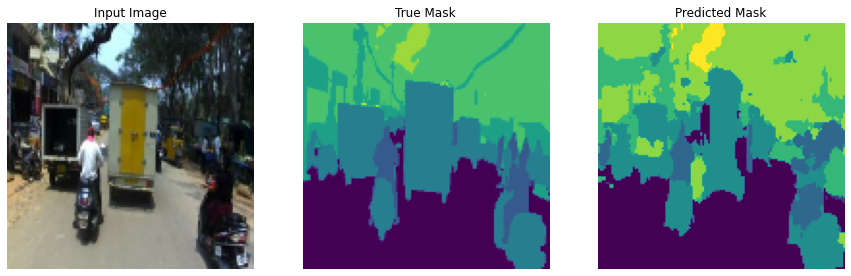


IoU Calculation for Sample Image = 

class 00: #TP=  4457, #FP=   341, #FN=  208, IoU=0.890
class 01: #TP=     0, #FP=    22, #FN=    8, IoU=0.000
class 02: #TP=   520, #FP=   613, #FN=  175, IoU=0.398
class 03: #TP=  2779, #FP=   897, #FN= 1141, IoU=0.577
class 04: #TP=   587, #FP=  1179, #FN=  642, IoU=0.244
class 05: #TP=  3831, #FP=   902, #FN=  746, IoU=0.699
class 06: #TP=   237, #FP=    19, #FN=   16, IoU=0.871
class 07: #TP=     0, #FP=     0, #FN=    1, IoU=0.000

Mean Intersection over union for example image :  0.4598887112577973

Time taken =  98.67954087257385


In [10]:
PipeLine(dataset_path, img_train, seg_train, img_val, seg_val)